In [126]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend
%matplotlib inline

In [129]:
from load_dataset import Dataset

In [130]:
dataset = Dataset('../data/dataset/')

In [131]:
# возьмем временной ряд, характеризующий продажи алкоголя по месяцам
ts = dataset["alcohol_sales.csv"]

In [132]:
ts, ts_test = ts[:250], ts[250:]

<AxesSubplot:xlabel='0'>

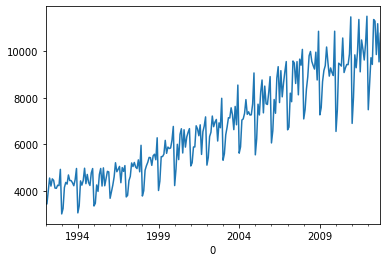

In [133]:
ts.plot()

## Box-Jenkins

In [134]:
# как можно заметить, у него есть окололинейный тренд, гетероскедастичность, сезонный период равен 12 (месяцам)

In [135]:
# сначала уберем гетероскедастичность простым логарифмированием
ts_log = np.log(ts)
plotting.plot_ts(ts_log)

Loading BokehJS ...

In [136]:
# Теперь подберем порядки дифференцирования d, D
# d малое подбирается таким образом, что d раз продифференцировав ряд, мы добьемся стационарности
# обычно таким дифференцированием убирают тренды
# D большое обычно подбирается так, что если d малое не дало стацинарности, мы можем D раз сезонно придифференцировать
# ряд, пока он не станет стационарным.

In [137]:
# для начала просто продифференцируем один раз

<AxesSubplot:xlabel='0'>

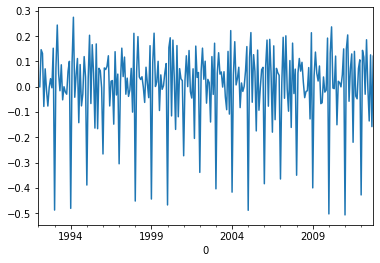

In [138]:
ts_log.diff().plot()

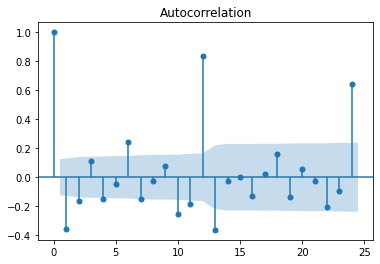

In [139]:
# в данном случае ряд сохраняет сезонность
plot_acf(ts_log.diff().dropna());

<AxesSubplot:xlabel='0'>

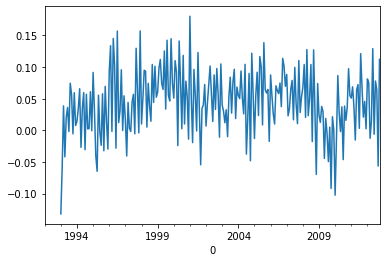

In [140]:
# попробуем применить сезонное дифференцирование 
ts_log.diff(12).plot()

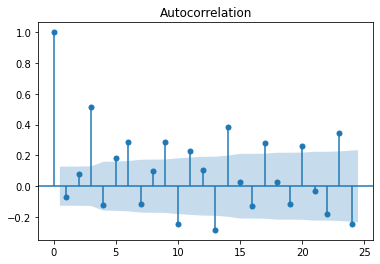

In [141]:
plot_acf(ts_log.diff(12).dropna());

In [142]:
# уже лучше
# посмотрим, что скажет критерий Дики Фуллера
# видим, что пока мы не можем отвергнуть нулевую гипотезу
adfuller(ts_log.diff(12).dropna())[1]

0.1282703781632084

<AxesSubplot:xlabel='0'>

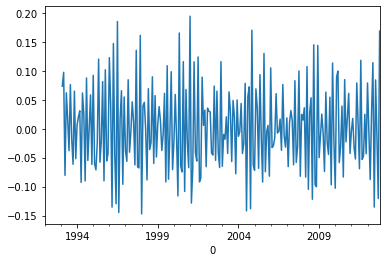

In [143]:
# давайте тогда попробуем обьединить сезонное и простое дифференцирования
ts_log.diff(12).diff().plot()

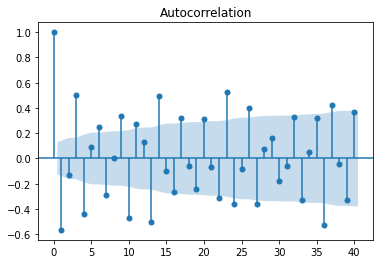

In [144]:
plot_acf(ts_log.diff(12).diff().dropna(), lags=40);

In [145]:
adfuller(ts_log.diff(12).diff().dropna())[1]

2.9448496463561783e-10

In [146]:
# отлично, вердикт о стационарности подтвержден, (d, D) = (1, 1)

In [147]:
# теперь разберемся с параметрами q, Q, p, P.

In [148]:
ts_flat = ts_log.diff(12).diff().dropna()

<AxesSubplot:xlabel='0'>

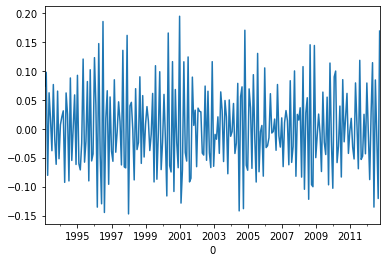

In [149]:
ts_flat.plot()

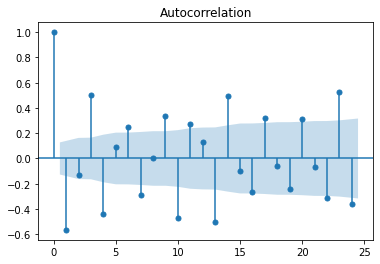

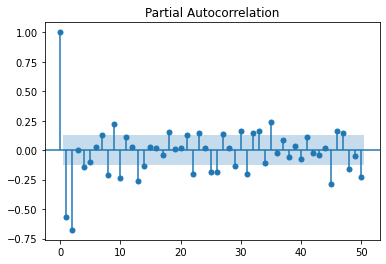

In [150]:
# отлично, для поиска параметров q, Q, p, P нарисуем график автокорреляции и частичной автокорреляции
# на графиках мы видим что резкое падение частичной автокорреляции, и плавное затухание полной автокорреляции,
# следовательно, наш ряд может быть описан моделью (p, d, 0), (P, D, 0). Итак, q = 0, Q = 0.
plot_acf(ts_flat.dropna());
plot_pacf(ts_flat, lags=50);

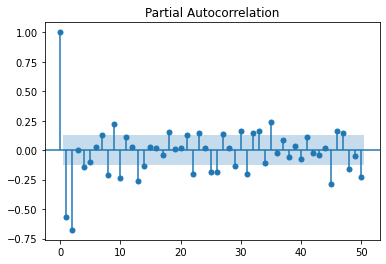

In [151]:
# найдем теперь параметры p, P
# p малое определяется как последний несезонный лаг, находящийся выше доверительного интервала
# в данном случае это p = 2, аналогично с сезонными лагами мы не видим никаких сезонных всплесков, 
# значит P = 0, итак (p, P) = (2, 0)
plot_pacf(ts_flat, lags=50);

In [152]:
# теперь попробуем построить SARIMA с этими параметрами

In [153]:
from statsmodels.tsa.statespace import sarimax

In [154]:
pdq = (2, 1, 0)
PDQ = (0, 1, 0, 12)

In [155]:
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

/Users/gsinyakov/ts_summer/.env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/gsinyakov/ts_summer/.env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [156]:
res = model.fit()

In [157]:
preds = res.forecast(69)

In [158]:
plotting.plot_ts(ts_log, preds)

Loading BokehJS ...

In [159]:
# восстановим в изначальном масштабе
plotting.plot_ts(np.exp(ts_log), np.exp(preds), ts_test)

Loading BokehJS ...

In [160]:
# Видим что получилось весьма неплохо!

In [161]:
# чтобы убедиться еще раз, давайте проанализируем остатки

In [162]:
res = (np.exp(preds) - ts_test)

<AxesSubplot:>

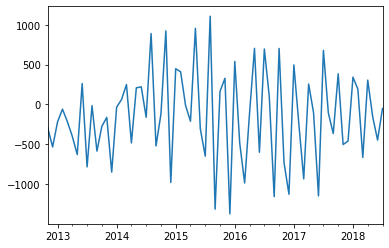

In [163]:
res.plot()

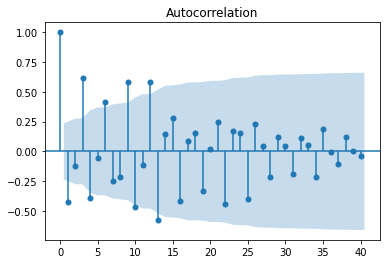

In [164]:
plot_acf(res, lags=40);

In [165]:
adfuller(res)[1]

0.21097252087392787

## Auto arima

In [166]:
from pmdarima import auto_arima

In [118]:
model = auto_arima(
     ts_log, start_p=0, start_q=0,
     max_p=3, max_q=3, m=12,
     start_P=0, start_Q=0, seasonal=True,
     d=1, D=1, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-556.970, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-647.918, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-649.023, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-803.158, Time=0.14 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-806.341, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-823.880, Time=0.74 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-679.155, Time=0.63 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-822.275, Time=1.03 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-822.639, Time=1.27 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-